In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# import necessary packages

import cv2
import numpy as np
import matplotlib.pyplot as plt
from measure_utils import *
from stat_utils import *

In [2]:
def get_cnts(img):
    gray_r = img[:, :, 0].copy()
    gray_g = img[:, :, 1].copy()
    gray_b = img[:, :, 2].copy()

    contours_r, hierarchy = cv2.findContours(gray_r, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_g, hierarchy = cv2.findContours(gray_g, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_b, hierarchy = cv2.findContours(gray_b, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Separate the contours
    return contours_r[0], contours_g[0], contours_b[0]

In [4]:
def plot_two_in_one_col(ax_0, ax_1, img, thickness, y_label=True):
    ax_0.imshow(img)
    ax_0.axis('off')
    
    weights_outer = np.ones_like(thickness)/float(len(thickness))
    bins = np.linspace(0, 1, 15)
    ax_1.hist(thickness, bins=bins, weights=weights_outer, alpha=0.5)
    ax_1.set_yticks(np.arange(0, 1.1, step=0.2))
    ax_1.set_xlabel("Thickness", fontsize=12)
    if y_label:
        ax_1.set_ylabel("Probability", fontsize=12)


def numerical_validation(img):
    
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    plt.subplots_adjust(hspace=0)

    outer, middle, inner = get_cnts(img)

    thickness_outer, thickness_inner, thickness_wall =  measure_thickness("", "", outer, middle, inner, 
                                                                          img.copy(), angle_width=10, exclude=[])

    # clip and normalize
    thick_media, thick_intima = clip_normalize(thick_media = thickness_outer, 
                                               thick_intima = thickness_inner, 
                                               thick_wall = thickness_wall, plot_hist=None)
    
    plot_two_in_one_col(axs[0, 0], axs[1, 0], img, thick_media)

    for i in range(4):
        # Define the new locations for each pixel
        rows, cols = img.shape[:2]
        map_x, map_y = np.meshgrid(np.arange(cols), np.arange(rows))
        map_x = map_x + 30 * np.sin(map_y/150*(i+1))
        map_y = map_y + 30 * np.cos(map_x/150*(i+1))
        map_x = map_x.astype(np.float32)
        map_y = map_y.astype(np.float32)

        # Apply the distortion to the image
        distorted_img = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
        outer, middle, inner = get_cnts(distorted_img)
        thickness_outer, thickness_inner, thickness_wall =  measure_thickness("", "", outer, middle, inner, 
                                                                              distorted_img.copy(), angle_width=10, exclude=[])
        # clip and normalize
        thick_media, thick_intima = clip_normalize(thick_media = thickness_outer, 
                                                   thick_intima = thickness_inner, 
                                                   thick_wall = thickness_wall, plot_hist=None)
        
        plot_two_in_one_col(axs[0, i+1], axs[1, i+1], distorted_img, thick_media, y_label=False)

    # Display the original and distorted images side by side
    plt.show()


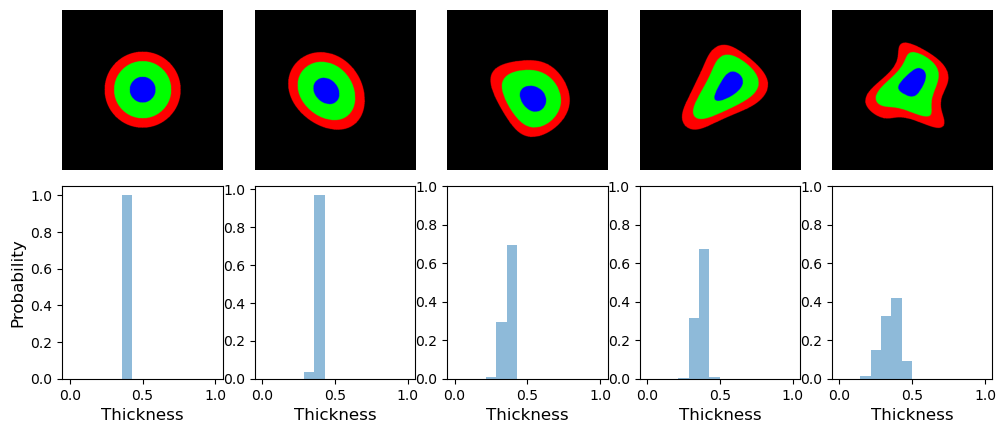

In [5]:
# Create a black image with a white circle
img_full = np.zeros((512, 512, 3), np.uint8)
cv2.circle(img_full, (256, 256), 121, (255, 0, 0), -1)
cv2.circle(img_full, (256, 256), 91, (0, 255, 0), -1)
cv2.circle(img_full, (256, 256), 41, (0, 0, 255), -1)

numerical_validation(img_full)

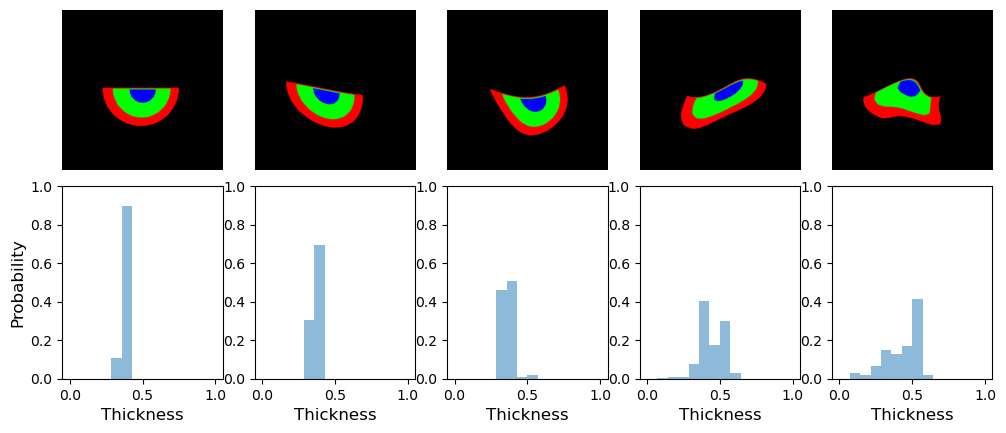

In [6]:
# Create a black image with a white circle
img_edge = np.zeros((512, 512, 3), np.uint8)
cv2.ellipse(img_edge, (250, 250), (121, 121), 0, 0, 180, (255, 0, 0), -1)
cv2.ellipse(img_edge, (253, 253), (91, 91), 0, 0, 180, (0, 255, 0), -1)
cv2.ellipse(img_edge, (256, 256), (41, 41), 0, 0, 180, (0, 0, 255), -1)

numerical_validation(img_edge)